In [3]:
from expkit import ExpSetup,Exp, DiskStorage
from expkit.ops import (
    EvalTotalMean,
    EvalMeanLast,
    EvalMeanMax,
    Operation,
    proj,
    OperationType,
)
from expkit.storage import CachedRODiskStorage

from functools import partial
import numpy as np
import gc
# beta in used by the rlhf model: 0.0325
N = 2048
TEMP = 0.8
n=128
N_MEASURAMENTS=[1,2,4,8,16,32,64,128]
eval_key = "correctedqe:Unbabel-XCOMET-XL"
# "qe:Unbabel-wmt23-cometkiwi-da-xl"
# "correctedqe:Unbabel-XCOMET-XL"
LP ="en-cs"
# betas : 0.02 0.05 0.2 0.5 # 0.01 0.1 1
# temp : 0.2, 0.3 ,0.4 ,0.5 ,0.6, 0.7 ,0.8 ,0.9, 1.0

def nondiagmean(x):
    x = x.squeeze()
    return x.sum() / (
        x.shape[0] * (x.shape[0] - 1)
    )


storage = CachedRODiskStorage(
    base_dir="/gscratch/ark/graf/quest-decoding/examples/mt/mt-outputs/",
)

In [6]:
storage.query({"variant":"ancestral","steps":128,"lp":"en-cs"})

AttributeError: 'CachedRODiskStorage' object has no attribute 'query'

In [ ]:


def topkxcomet(exp, k=16, proxy="qe:Unbabel-wmt23-cometkiwi-da-xl", target="correctedqe:Unbabel-XCOMET-XL"):
    
    for pi, gti in zip(exp.get_eval(proxy),exp.get_eval(target)):
        print pi, gti 
        break
        
    return exp.get_eval(proxy).sort_values(by=target, ascending=False).head(k).mean()

"""Operation(
    type=OperationType.EXP,
    func=lambda instance_evals: np.mean(
        list(
            map(
                lambda x: nondiagmean(np.array(x["scores"])),
                instance_evals,
            )
        )
    ),
    key="pairwise-bleu-repr",
),"""

In [82]:
setup = ExpSetup(
    storage,
    ops={
        "diversity": Operation(
            type=OperationType.EVAL,
            func=lambda instance_evals: np.mean(list(
                map(
                    lambda x: nondiagmean( 
                        np.array(x["scores"])),
                    instance_evals,
                )
            )),
            key="pairwise-bleu-repr",
        ),
        **{
            f"mean-reward-{n}": EvalTotalMean(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
        **{
            f"last-reward-{n}": EvalMeanLast(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
        **{
            f"max-reward-{n}": EvalMeanMax(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
    },
).query(
    {"steps": 128}
)

In [83]:
missing = setup.filter(lambda e: not e.has_eval(eval_key))
for exp in missing.experiments[::-1]:
    print(exp.name)
    print(exp.get("language_pair"))
    print(exp.meta["at"])
    # print(exp.get("beta"))
    print("--" * 40)

In [84]:
setup=setup.query({"language_pair": LP}).sort("at")

In [85]:
setup.meta()

[{'beta': 1.0,
  'steps': 128,
  'temperature': 0.8,
  'model_path': 'haoranxu/ALMA-7B',
  'reward_model_path': 'Unbabel/wmt23-cometkiwi-da-xl',
  'variant': 'quest',
  'reward_type': 'contextual',
  'stop_tokens': [],
  'index': 'uniform',
  'max_new_tokens': 800,
  'max_prompt_length': 1200,
  'at': '2024-08-02T11:18:38.854738',
  'language_pair': 'en-cs',
  'llm': 'alma'},
 {'steps': 128,
  'temperature': 0.1,
  'model_path': 'haoranxu/ALMA-7B',
  'variant': 'ancestral',
  'stop_tokens': [],
  'index': 'uniform',
  'max_new_tokens': 800,
  'max_prompt_length': 1200,
  'at': '2024-08-03T19:59:11.188316',
  'language_pair': 'en-cs',
  'llm': 'alma'},
 {'beta': 0.1,
  'steps': 128,
  'temperature': 0.8,
  'model_path': 'haoranxu/ALMA-7B',
  'reward_model_path': 'Unbabel/wmt23-cometkiwi-da-xl',
  'variant': 'quest',
  'reward_type': 'contextual',
  'stop_tokens': [],
  'index': 'uniform',
  'max_new_tokens': 800,
  'max_prompt_length': 1200,
  'at': '2024-08-03T20:07:33.453674',
  'lang

In [86]:
for exp in setup.experiments[::-1]:
    print(exp.name)
    print(exp.evals().keys())
    print(exp.meta["at"])
    try:
        print(exp.get("beta"))
    except:
        pass
    print("--"*40)

e7efa4bc-1dc9-450d-b04f-da9afa0f5179
dict_keys(['pairwise-bleu-repr', 'correctedqe:Unbabel-XCOMET-XL'])
2024-09-28T00:50:22.139570
--------------------------------------------------------------------------------
3a493aca-697c-4d28-b65d-7c190f484a25
dict_keys(['pairwise-bleu-repr', 'correctedqe:Unbabel-XCOMET-XL'])
2024-09-27T22:30:33.661908
--------------------------------------------------------------------------------
27e1bfff-d882-4ec2-b566-fc9807b20ffe
dict_keys(['pairwise-bleu-repr', 'correctedqe:Unbabel-XCOMET-XL'])
2024-09-27T20:13:22.165118
--------------------------------------------------------------------------------
41ccf306-eb75-480a-b0a2-f19272fdb759
dict_keys(['pairwise-bleu-repr', 'correctedqe:Unbabel-XCOMET-XL'])
2024-09-27T17:57:56.190335
--------------------------------------------------------------------------------
528af419-0410-4f41-b65e-699e9b807ded
dict_keys(['pairwise-bleu-repr', 'correctedqe:Unbabel-XCOMET-XL'])
2024-09-27T15:42:26.630830
---------------------

In [87]:
base = setup.query(
    {
        "variant": "ancestral"#,"temperature":0.8
    }
)

print(
    base.get_support(
        ["temperature"]
    )
)

quest = (
    setup.query({"variant": "quest"})
    .unique("beta")
    .filter(
        lambda e: e.meta["beta"]
        in [1, 0.01, 0.1, 0.001, 0.02, 0.05, 0.2, 0.5]
    )
)
# quest.experiments=quest.experiments

# 1, 0.01, 0.1, 0.005, 0.001, 0.0001, 0.02, 0.05, 0.2, 0.5

quest.run_ops()
base.run_ops()
print("---" * 20)
print(LP)
print("base")
print(
    len(
        base.meta()
    )
)
print(
    list(map(
        proj("temperature"),
        base.meta()
    ))
)
print("quest")
print(
    len(
        quest.meta()
    )
)
print(
    list(map(
        proj("beta"),
        quest.meta(),
    ))
)

{'temperature': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
------------------------------------------------------------
en-cs
base
11
[0.1, 0.01, 1.0, 0.5, 0.8, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9]
quest
8
[1, 0.1, 0.01, 0.001, 0.02, 0.05, 0.2, 0.5]


In [88]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

sns.set_theme()

# sns.set(rc={"figure.figsize": (15, 10)})
sns.set(
    style="darkgrid",
    rc={
        "grid.alpha": 1,
        "grid.linewidth": "1",
    },
)
sns.set_context(
    font_scale=2.5,
    rc={"lines.linewidth": 4.5},
)

sns.set(font_scale=3)
import numpy as np
import pandas as pd

def plot_pareto_graph(
    comparisons,
    x_name,
    y_name,
    title,
    y_label=None,
    x_label=None,
    xlim=None,
    ylim=None,
):
    plt.figure(figsize=(15, 10))
    plt_data = []
    for (
        method,
        experiments,
    ) in comparisons.items():

        for exp in experiments:
            try:

                print(exp.ops_results)
                x = exp.ops_results[
                    x_name
                ]
                y = exp.ops_results[
                    y_name
                ]
                plt_data.append(
                    [
                        method,
                        exp.meta[
                            "temperature"
                        ],
                        x,
                        y,
                    ]
                )
            except Exception as e:
                print(e)
                pass

                # plt_data.append([method + f"-beta{exp.meta.get('beta', '')}", exp.meta["temperature"], x, y])
    plot_df = pd.DataFrame(plt_data)

    print(plt_data)

    plot_df.columns = [
        "Method",
        "τ",
        x_name,
        y_name,
    ]

    name_dict = {
        #"nucleus": "Nucleus",
        #"beam_sample": "Beam Sample",
        "ancestral": "Ancestral",
        "quest": "QUEST",
        #"mcmc-qe-rlhf": "QUEST-RLHF",
    }
    plot_df["Method"] = plot_df[
        "Method"
    ].apply(lambda x: name_dict[x])
    plot_df = plot_df[
        plot_df.Method.isin(
            [
                "Ancestral",
                "QUEST",
                #"QUEST-RLHF",
            ]
        )
    ]
    plot_df = plot_df.sort_values(
        by=[x_name]
    )

    plot_df["Method"] = pd.Categorical(
        plot_df["Method"],
        categories=[
            "QUEST",
            "Ancestral",
            # "QUEST-RLHF",
        ],
        ordered=True,
    )
    plot_df = plot_df.sort_values(
        by=["Method"]
    )

    plot_df[y_name] = plot_df[y_name] * 100
    plot_df[x_name] = plot_df[x_name] * 100
    # print(plot_df.head())

    ax = sns.scatterplot(
        plot_df,
        x=x_name,
        y=y_name,
        hue="Method",
        legend="brief",
        s=500,
    )
    ax = sns.lineplot(
        plot_df,
        x=x_name,
        y=y_name,
        hue="Method",
        legend=None,
    )

    # for method in plot_df.method.unique():
    #    xqd, yqd = fit_quadratic(plot_df[plot_df["method"]==method][x_name].to_list(), plot_df[plot_df["method"]==method][y_name].to_list())
    #    plt.plot(xqd, yqd)

    # plt.axhline(plot_df[(plot_df.Method=='ancestral') & (plot_df["τ"]==0.8)][y_name].values[0], linestyle="-.", color="black", linewidth=1)
    # plt.axvline(plot_df[(plot_df.Method=='ancestral') & (plot_df["τ"]==0.8)][x_name].values[0], linestyle="-.", color="black", linewidth=1)
    # plt.legend('',frameon=False)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.legend(loc='lower left', fontsize = 36)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x_label, fontsize=36)
    plt.ylabel(y_label, fontsize=36)

    # if xlim is not None:
    # plt.xlim(30, 80)

    # if ylim is not None:
    # plt.ylim(65, 90)

    plt.title(title, fontsize=40)
    plt.show()
    # plt.show()

    # plt.savefig(file_name)

{'diversity': 0.8055389796921613, 'mean-reward-1': 0.7404102494012395, 'mean-reward-2': 0.7404102494012395, 'mean-reward-4': 0.7489607809498653, 'mean-reward-8': 0.7565858374580902, 'mean-reward-16': 0.7640846241023912, 'mean-reward-32': 0.7717379745603108, 'mean-reward-64': 0.7760024507204986, 'mean-reward-128': 0.7802556158915366, 'last-reward-1': 0.7404102494012395, 'last-reward-2': 0.7404102494012395, 'last-reward-4': 0.7617378347046176, 'last-reward-8': 0.7641724068417843, 'last-reward-16': 0.7760962170484039, 'last-reward-32': 0.7784305992071788, 'last-reward-64': 0.7821637965721243, 'last-reward-128': 0.7855573738195513, 'max-reward-1': 0.7404102494012395, 'max-reward-2': 0.7404102494012395, 'max-reward-4': 0.808746899892647, 'max-reward-8': 0.8544477623422903, 'max-reward-16': 0.8931912844549494, 'max-reward-32': 0.9205075047549539, 'max-reward-64': 0.9404334729048877, 'max-reward-128': 0.954699360574108}
{'diversity': 0.5765198155353674, 'mean-reward-1': 0.7404102475967459, 'm

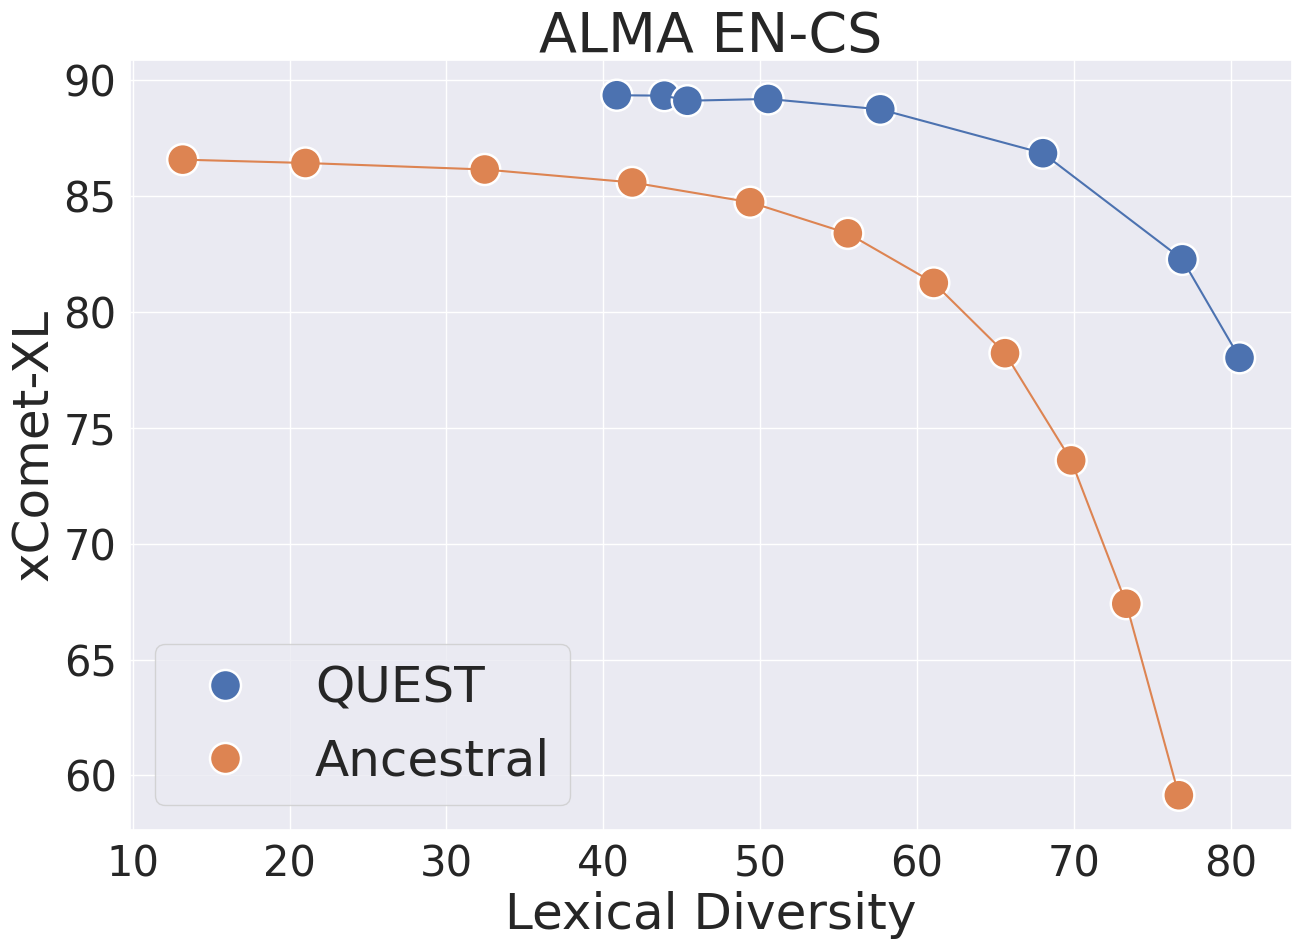

In [89]:
plot_pareto_graph(
    {"quest": quest, "ancestral": base},
    "diversity",
    "mean-reward-128",
    f"ALMA {LP.upper()}",
    y_label="xComet-XL",
    x_label=f"Lexical Diversity",
    xlim=None,
    ylim=None,
)